<a href="https://colab.research.google.com/github/zualexander/mai-aiapp-computer-vision/blob/main/mai_computer_vision_experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import (SGD, RMSprop)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tarfile
import os
import splitfolders
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#variables

In [9]:
batch_size = 32
epochs = 50
img_size = 256
train_data_path = '/tmp/dataset/output/train/'
val_data_path = '/tmp/dataset/output/val/'

#Functions

In [1]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy_and_loss(history):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Download Dataset
from [howto](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e)

In [5]:
!wget --no-check-certificate \
    ""http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"" \
    -O "/tmp/dataset.tar.gz"

--2022-05-29 19:43:31--  http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz
Resolving aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)... 132.230.105.132
Connecting to aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)|132.230.105.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541562880 (516M) [application/x-gzip]
Saving to: ‘/tmp/dataset.tar.gz’

/tmp/dataset.tar.gz 100%[===================>] 516.47M  19.4MB/s    in 27s     

2022-05-29 19:43:58 (19.4 MB/s) - ‘/tmp/dataset.tar.gz’ saved [541562880/541562880]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir /tmp/dataset 
!tar xf /tmp/dataset.tar.gz --directory=/tmp/dataset

mkdir: cannot create directory ‘/tmp/dataset’: File exists


# Datasplit

In [10]:
splitfolders.ratio("/tmp/dataset/images", output="/tmp/dataset/output",
    seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 4947 files [00:01, 2772.87 files/s]


In [11]:
ls /tmp/dataset/output/train

BEANS/   CHIPS/      FISH/   JUICE/  PASTA/   SUGAR/         WATER/
CAKE/    CHOCOLATE/  FLOUR/  MILK/   RICE/    TEA/
CANDY/   COFFEE/     HONEY/  NUTS/   SODA/    TOMATO_SAUCE/
CEREAL/  CORN/       JAM/    OIL/    SPICES/  VINEGAR/


In [12]:
train = keras.utils.image_dataset_from_directory(
    directory=train_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))

validation = keras.utils.image_dataset_from_directory(
    directory=val_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))


Found 3699 files belonging to 25 classes.
Found 1248 files belonging to 25 classes.


In [18]:
print(len(train.class_names))
classes=train.class_names

25


## data generator

In [13]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(                      
    rotation_range=90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2
    )

In [14]:
val_datagen = keras.preprocessing.image.ImageDataGenerator()

In [15]:
train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 3699 images belonging to 25 classes.


In [16]:
val_generator = val_datagen.flow_from_directory(val_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 1248 images belonging to 25 classes.


#ResNet Model

In [19]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
    classes=len(classes)
) 

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

In [17]:
resnet_model.count_params()

23587712

#Inception Model

In [20]:
classes = np.unique(train)
nClasses = len(classes)

First inception layer:

In [22]:
# input_img = Input(shape=(img_size, img_size, 1))

ind = 0
for layer in resnet_model.layers[:-1]:
  ind += 1
  if layer.name == 'conv3_block4_out':
    break

x = resnet_model.layers[ind].output

layer_1 = Conv2D(10, (1,1), padding='valid', activation='relu')(x)#(input_img)
layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(layer_1)

layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(x)
layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

Add dense layers:

In [23]:
flat_1 = Flatten()(mid_1)

dense_1 = Dense(300, activation='relu')(flat_1)
dense_2 = Dense(150, activation='relu')(dense_1)
dense_3 = Dense(75, activation='relu')(dense_2)
output = Dense(nClasses, activation='softmax')(dense_3)

In [28]:
model_inception = Model([x], output)

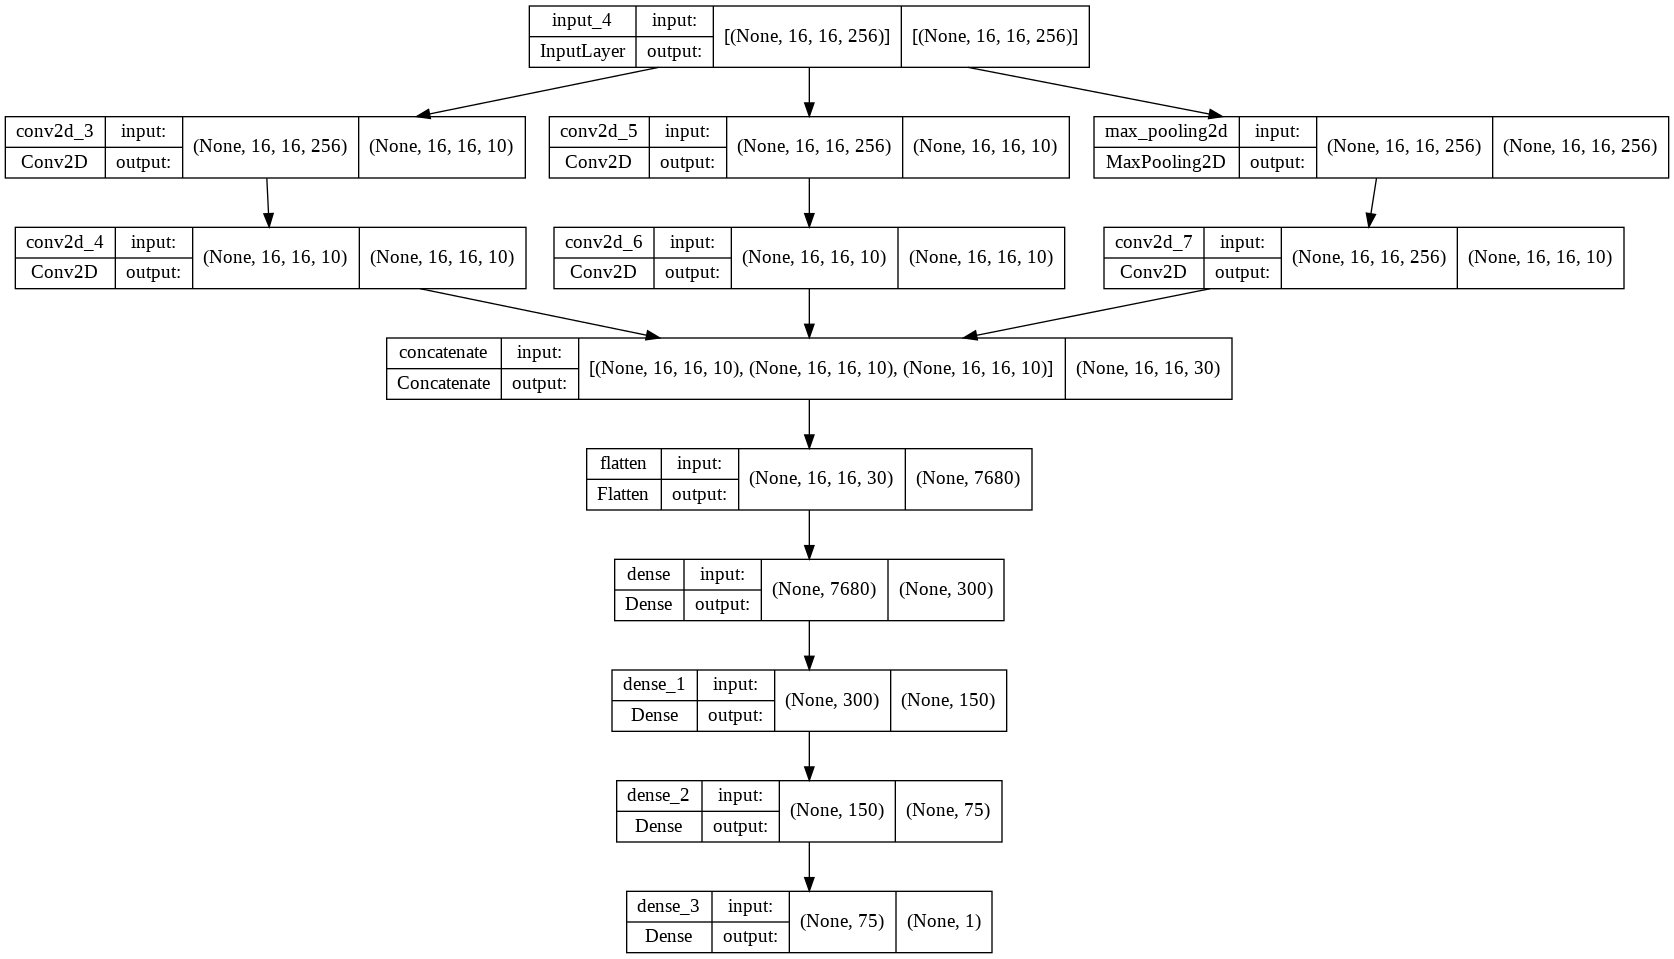

In [41]:
plot_model(model_inception, to_file='model.png', show_shapes=True, show_layer_names=True)

Getting output of ResNet50 layer conv3_block4_out:

In [42]:
model = keras.models.Sequential()

for layer in model_inception.layers:
  layer.trainable=False

In [43]:
model.add(model_inception)

In [36]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(len(classes), activation='softmax'))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1)                 2371981   
                                                                 
 flatten_2 (Flatten)         (None, 1)                 0         
                                                                 
 dense_6 (Dense)             (None, 512)               1024      
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,373,518
Trainable params: 1,537
Non-trainable params: 2,371,981
_________________________________________________________________


In [38]:
model.count_params()

2373518

In [39]:
#compile model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

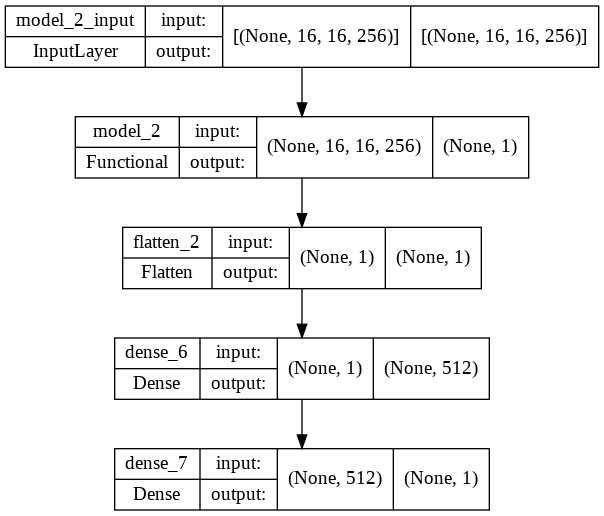

In [40]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
hist = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/50
116/116 [==============================] - 1154s 10s/step - loss: 15.7453 - acc: 0.1052 - val_loss: 2.9305 - val_acc: 0.1186
Epoch 2/50
116/116 [==============================] - 1125s 10s/step - loss: 2.8731 - acc: 0.1817 - val_loss: 2.7654 - val_acc: 0.2196
Epoch 3/50
116/116 [==============================] - 1120s 10s/step - loss: 2.7783 - acc: 0.2130 - val_loss: 2.5668 - val_acc: 0.2604
Epoch 4/50


#Model evaluation

##trainigs history

In [ ]:
print ("test accuracy ", hist.history['acc'][-1])

#validation history

In [ ]:
print ("validation accuracy ", hist.history['val_acc'][-1])

#accuracy and loss plot

In [ ]:
print(hist.history.keys())
plot_accuracy_and_loss(hist)

#Confusion matrix

In [ ]:
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
con_mat = confusion_matrix(val_generator.classes, y_pred)
print('Confusion Matrix')
print(con_mat)
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=classes))

In [ ]:
## plot

In [ ]:
sns.set_theme(style='darkgrid')

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Dark2)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()